## Imports

In [1]:
# DATA MANIPULATION
import numpy as np

# DATA VISUALIZATION
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler

# BLOB DATASET
from sklearn.datasets import make_blobs

# KERAS
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

2023-08-15 14:49:42.796675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# How to Properly Prevent Overfitting

🎯 **Goals of this challenge**
- **`Cross Validate`** a Deep Learning Model
- Give a **`Validation Set`** to the model
- Apply two techniques to prevent overfitting:
    - Use the **`Early Stopping`** criterion to prevent the Neural network from over-learning / over-fitting
    - **`Regularize`** your network
- Analyze the **`impact of the batch size and the number of epochs`** on the training of a Neural Network

## Data - the `blobs` Dataset

### Generating a Blobs Dataset

First, let's generate some data using the [`make_blobs`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function from Scikit-Learn

Generate 2000 samples with 10 features each; there should be 8 classes of blobs (`centers` argument) with `cluster_std` equal to 7.

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=2000, centers=8, n_features=10,random_state=0, cluster_std = 7)

### Visualizing the Dataset

All your samples have 10 features. Plot one of the dimensions against another.

Text(0.5, 1.0, 'Scatter Plot of Two Features')

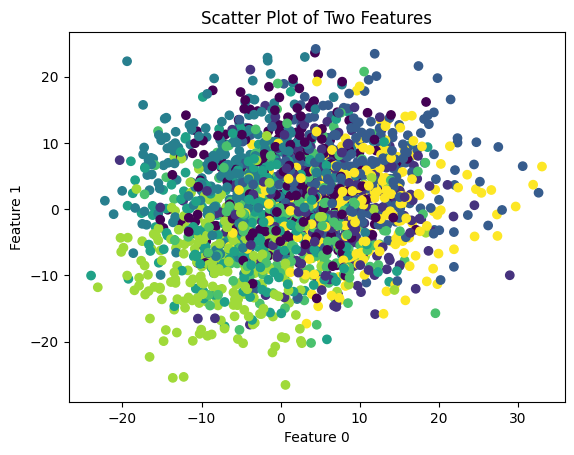

In [3]:
import matplotlib.pyplot as plt

feature1 = 0 
feature2 = 1 

plt.scatter(X[:, feature1], X[:, feature2], c=y, cmap='viridis')
plt.xlabel(f"Feature {feature1}")
plt.ylabel(f"Feature {feature2}")
plt.title("Scatter Plot of Two Features")



### Encoding your Categorical Target

Use the 📚 [**to_categorical()**](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) function to convert `y` to `y_cat`, which is the categorical representation of `y` with **One-Hot encoded** columns.

In [4]:
from keras.utils import to_categorical
import tensorflow as tf

y_cat = to_categorical(y, num_classes=None, dtype='float32')

y_cat = tf.keras.utils.to_categorical(y, num_classes=None, dtype='float32')

y_cat.shape

(2000, 8)

## (1) Cross-Validation in Deep Learning

👩🏻‍🏫 In a previous challenge, we split the dataset into a training set and a testing set at the beginning of the notebook. Then, we started to build different models which were trained on the training set and evaluated on the testing set.

So, at the end of the day, we used the testing set every time we evaluated our models and different hyperparameters. This is normal: we always train on the training set and we evaluate on the testing set.

However, we selected our "best model" based on the score of each model. In other words, we _used_ the test set to select our best model, which means there was ❗️ `data leakage` ❗️

🤔 **what should we do?**

- A first good practice is to avoid using `random_state` or any deterministic separation between your training and testing sets. In that case, your testing set will change every time you re-run your notebook. This is far from being sufficient, though
- To compare models properly, you have to run a cross-validation, a 10-fold split, for instance

🧐 If you look at [sklearn.model_selection.cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html), this Cross -Validation tool is designed for Machine Learning algorithms implemented in Scikit Learn, whereas we have been creating and using Neural Networks from Tensorflow/Keras.

🔥 Let's discover how to **Cross-validate a Neural Network**.

### Designing a Neural Network

First, write a function that generates a Neural Network with 3 layers:

<u>Architecture</u>
- an **input layer** with 25 neurons, the `relu` activation function and the appropriate `input_dim`
- a **hidden layer** with 10 neurons and the `relu` activation function.
- a **predictive layer** that is suited to the problem at hand (*multiclass classification*)

<u>Compilation</u>

The function should include a compilation method with:
- the *categorical_crossentropy* loss
- the *Adam* optimizer 
- the *accuracy* metric

In [19]:
from keras.models import Sequential
from keras.layers import Dense

def initialize_model(input_dim, num_classes):
    
    model = Sequential()
    
    model.add(Dense(25, input_dim=input_dim, activation='relu'))
    
    model.add(Dense(10, activation='relu'))
    
    model.add(Dense(num_classes, activation='softmax'))
  
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


### Cross-Validating the Neural Net

🧑🏻‍💻 Write a _loop_ using the [K-Fold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) function from Scikit-Learn.

* ✂️ Choose 10 splits to fit your model on the training data
* 🧪 Evaluate your model on the testing data, and store the results of the evaluation into a `results` variable.

_Hints_:
* ⚖️ Do not forget to standardize your training data before fitting the NN
* 👌 150 epochs should be sufficient for a first approximation
* 🤝 As this is your first Deep Learning Cross-Validation, you are guided; just uncomment the following cell and follow the steps
* ⏳ Notice that we added `%% time` at the beginning of this Jupyter Notebook cell to display its running time, and we encourage you to do so whenever you run expensive computations

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

num_classes = len(np.unique(y))

kf = KFold(n_splits=10)

results = []

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = Sequential()
    
    model.add(Dense(25, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train_scaled, to_categorical(y_train), epochs=150, verbose=0)
    
    accuracy = model.evaluate(X_test_scaled, to_categorical(y_test), verbose=0)
    results.append(accuracy[1]) 

accuracy = results
print(f'New mean accuracy: {np.mean(accuracy)*100:.2f}% (±{np.std(accuracy)*100:.2f})')


### Performance of the Cross-Validated Network

Print the average accuracy of these 10 folds and the standard deviation of these 10 accuracy values.

In [ ]:
accuracy = results
print(f'New mean accuracy: {np.mean(accuracy)*100:.2f}% (±{np.std(accuracy)*100:.2f})')

### Remarks About the Computational Time

- 🤯 You probably encountered one of the main drawbacks of using proper cross-validation for a Neural Network: **it takes a lot of time**! Therefore, for the rest of the Deep-Learning module, we will do **only one fold**
- 👮🏻‍♀️ Remember that this is not entirely correct and, for real-life applications and problems, you are encouraged to use a proper cross-validation technique
- 💼 In general, people split only once, as you did. Once they get to the end of their optimization, they launch a real cross-validation run at 6 PM, go home and get the final results on the next day

### Holdout Method

For the rest of the exercise (and of the Deep Learning module), split the dataset into a training set and a testing set with a 70/30% training-to-test data ratio.

Make sure to also scale the data after splitting!

In [6]:
x_train, x_test, y_train,y_test=train_test_split(X, y_cat ,test_size=0.3)

In [7]:
SScaler = StandardScaler()
SScaler.fit(x_train)

X_train_scaled = SScaler.transform(x_train)
X_test_scaled = SScaler.transform(x_test)

## (2) How to Prevent a Neural Network from Overfitting?

### (2.1) Early Stopping

🚦 **Stop the learning process before overfitting**

#### Illustrating How a Neural Network Easily Overfits

First things first, let's show that if we train the model for too long (= for too many epochs) it will overfit the training data and will not be good at predicting the testing data.

**How can we do it without using the testing data, which is strictly forbidden?**

You can use a fraction of the <font color=blue>training set</font> as a <font color=green>validation set</font>.

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/deep-learning/02/validation_set.png" width=450>

With Keras, you don't have to re-use the `train_test_split` method from Scikit-Learn. Instead, you have two options:

- `validation_split = 0.2` (for example)
    - The model will take the last 20% of the observations in the training set and use this group as the validation holdout set
    - If you want a random `train_val_split` within the training set, you can also add the argument `shuffle = True` in `model.fit()`
- `validation_data = (X_val, y_val)` if you have access to a dataset that you want to use as the validation holdout set.

👉 Let's go with the first option and set `epochs = 500`. 

👉 Store the performances of the model in a `history` variable.

In [20]:
%%time

from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split


model = initialize_model(10, 8)

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=500,  verbose=1)

history 

Epoch 1/500
35/35 [==============================] - 1s 5ms/step - loss: 2.1741 - accuracy: 0.1045 - val_loss: 2.0039 - val_accuracy: 0.1286
Epoch 2/500
35/35 [==============================] - 0s 1ms/step - loss: 1.9557 - accuracy: 0.1384 - val_loss: 1.8701 - val_accuracy: 0.1893
Epoch 3/500
35/35 [==============================] - 0s 2ms/step - loss: 1.8107 - accuracy: 0.2259 - val_loss: 1.7595 - val_accuracy: 0.2929
Epoch 4/500
35/35 [==============================] - 0s 2ms/step - loss: 1.6759 - accuracy: 0.3580 - val_loss: 1.6450 - val_accuracy: 0.3929
Epoch 5/500
35/35 [==============================] - 0s 1ms/step - loss: 1.5411 - accuracy: 0.4768 - val_loss: 1.5200 - val_accuracy: 0.4679
Epoch 6/500
35/35 [==============================] - 0s 1ms/step - loss: 1.4070 - accuracy: 0.5545 - val_loss: 1.4029 - val_accuracy: 0.5357
Epoch 7/500
35/35 [==============================] - 0s 1ms/step - loss: 1.2765 - accuracy: 0.6196 - val_loss: 1.2896 - val_accuracy: 0.5893
Epoch 8/500
3

Epoch 59/500
35/35 [==============================] - 0s 1ms/step - loss: 0.5131 - accuracy: 0.8107 - val_loss: 0.6804 - val_accuracy: 0.7679
Epoch 60/500
35/35 [==============================] - 0s 1ms/step - loss: 0.5133 - accuracy: 0.8143 - val_loss: 0.6820 - val_accuracy: 0.7607
Epoch 61/500
35/35 [==============================] - 0s 1ms/step - loss: 0.5112 - accuracy: 0.8152 - val_loss: 0.6830 - val_accuracy: 0.7679
Epoch 62/500
35/35 [==============================] - 0s 1ms/step - loss: 0.5098 - accuracy: 0.8080 - val_loss: 0.6815 - val_accuracy: 0.7714
Epoch 63/500
35/35 [==============================] - 0s 1ms/step - loss: 0.5088 - accuracy: 0.8134 - val_loss: 0.6824 - val_accuracy: 0.7679
Epoch 64/500
35/35 [==============================] - 0s 1ms/step - loss: 0.5079 - accuracy: 0.8107 - val_loss: 0.6832 - val_accuracy: 0.7679
Epoch 65/500
35/35 [==============================] - 0s 1ms/step - loss: 0.5065 - accuracy: 0.8152 - val_loss: 0.6828 - val_accuracy: 0.7714
Epoch 

35/35 [==============================] - 0s 2ms/step - loss: 0.4594 - accuracy: 0.8321 - val_loss: 0.6991 - val_accuracy: 0.7643
Epoch 117/500
35/35 [==============================] - 0s 2ms/step - loss: 0.4590 - accuracy: 0.8321 - val_loss: 0.7001 - val_accuracy: 0.7571
Epoch 118/500
35/35 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.8357 - val_loss: 0.7014 - val_accuracy: 0.7607
Epoch 119/500
35/35 [==============================] - 0s 2ms/step - loss: 0.4581 - accuracy: 0.8339 - val_loss: 0.7018 - val_accuracy: 0.7571
Epoch 120/500
35/35 [==============================] - 0s 2ms/step - loss: 0.4560 - accuracy: 0.8357 - val_loss: 0.7014 - val_accuracy: 0.7643
Epoch 121/500
35/35 [==============================] - 0s 1ms/step - loss: 0.4548 - accuracy: 0.8366 - val_loss: 0.7043 - val_accuracy: 0.7643
Epoch 122/500
35/35 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.8384 - val_loss: 0.7036 - val_accuracy: 0.7643
Epoch 123/500

35/35 [==============================] - 0s 1ms/step - loss: 0.4171 - accuracy: 0.8571 - val_loss: 0.7447 - val_accuracy: 0.7679
Epoch 174/500
35/35 [==============================] - 0s 1ms/step - loss: 0.4188 - accuracy: 0.8464 - val_loss: 0.7414 - val_accuracy: 0.7750
Epoch 175/500
35/35 [==============================] - 0s 1ms/step - loss: 0.4164 - accuracy: 0.8545 - val_loss: 0.7472 - val_accuracy: 0.7679
Epoch 176/500
35/35 [==============================] - 0s 1ms/step - loss: 0.4157 - accuracy: 0.8473 - val_loss: 0.7448 - val_accuracy: 0.7786
Epoch 177/500
35/35 [==============================] - 0s 1ms/step - loss: 0.4149 - accuracy: 0.8527 - val_loss: 0.7461 - val_accuracy: 0.7679
Epoch 178/500
35/35 [==============================] - 0s 2ms/step - loss: 0.4138 - accuracy: 0.8473 - val_loss: 0.7457 - val_accuracy: 0.7679
Epoch 179/500
35/35 [==============================] - 0s 2ms/step - loss: 0.4135 - accuracy: 0.8562 - val_loss: 0.7483 - val_accuracy: 0.7714
Epoch 180/500

35/35 [==============================] - 0s 1ms/step - loss: 0.3880 - accuracy: 0.8562 - val_loss: 0.7856 - val_accuracy: 0.7679
Epoch 231/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3855 - accuracy: 0.8634 - val_loss: 0.7893 - val_accuracy: 0.7714
Epoch 232/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3859 - accuracy: 0.8562 - val_loss: 0.7908 - val_accuracy: 0.7750
Epoch 233/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3843 - accuracy: 0.8625 - val_loss: 0.7884 - val_accuracy: 0.7714
Epoch 234/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3852 - accuracy: 0.8607 - val_loss: 0.7931 - val_accuracy: 0.7679
Epoch 235/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3826 - accuracy: 0.8634 - val_loss: 0.7933 - val_accuracy: 0.7679
Epoch 236/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3855 - accuracy: 0.8580 - val_loss: 0.7896 - val_accuracy: 0.7786
Epoch 237/500

35/35 [==============================] - 0s 1ms/step - loss: 0.3638 - accuracy: 0.8714 - val_loss: 0.8307 - val_accuracy: 0.7643
Epoch 288/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3645 - accuracy: 0.8679 - val_loss: 0.8345 - val_accuracy: 0.7643
Epoch 289/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3650 - accuracy: 0.8687 - val_loss: 0.8343 - val_accuracy: 0.7679
Epoch 290/500
35/35 [==============================] - 0s 2ms/step - loss: 0.3627 - accuracy: 0.8714 - val_loss: 0.8306 - val_accuracy: 0.7607
Epoch 291/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3636 - accuracy: 0.8679 - val_loss: 0.8371 - val_accuracy: 0.7750
Epoch 292/500
35/35 [==============================] - 0s 2ms/step - loss: 0.3603 - accuracy: 0.8768 - val_loss: 0.8406 - val_accuracy: 0.7643
Epoch 293/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3614 - accuracy: 0.8661 - val_loss: 0.8403 - val_accuracy: 0.7500
Epoch 294/500

35/35 [==============================] - 0s 1ms/step - loss: 0.3456 - accuracy: 0.8813 - val_loss: 0.8668 - val_accuracy: 0.7571
Epoch 345/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3450 - accuracy: 0.8777 - val_loss: 0.8720 - val_accuracy: 0.7571
Epoch 346/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3448 - accuracy: 0.8795 - val_loss: 0.8778 - val_accuracy: 0.7500
Epoch 347/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3451 - accuracy: 0.8804 - val_loss: 0.8798 - val_accuracy: 0.7500
Epoch 348/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3443 - accuracy: 0.8777 - val_loss: 0.8718 - val_accuracy: 0.7571
Epoch 349/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3465 - accuracy: 0.8759 - val_loss: 0.8835 - val_accuracy: 0.7536
Epoch 350/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3436 - accuracy: 0.8777 - val_loss: 0.8760 - val_accuracy: 0.7571
Epoch 351/500

35/35 [==============================] - 0s 2ms/step - loss: 0.3274 - accuracy: 0.8830 - val_loss: 0.9203 - val_accuracy: 0.7607
Epoch 402/500
35/35 [==============================] - 0s 2ms/step - loss: 0.3277 - accuracy: 0.8813 - val_loss: 0.9235 - val_accuracy: 0.7571
Epoch 403/500
35/35 [==============================] - 0s 2ms/step - loss: 0.3290 - accuracy: 0.8875 - val_loss: 0.9232 - val_accuracy: 0.7536
Epoch 404/500
35/35 [==============================] - 0s 2ms/step - loss: 0.3281 - accuracy: 0.8839 - val_loss: 0.9218 - val_accuracy: 0.7536
Epoch 405/500
35/35 [==============================] - 0s 2ms/step - loss: 0.3282 - accuracy: 0.8902 - val_loss: 0.9229 - val_accuracy: 0.7571
Epoch 406/500
35/35 [==============================] - 0s 2ms/step - loss: 0.3255 - accuracy: 0.8875 - val_loss: 0.9235 - val_accuracy: 0.7536
Epoch 407/500
35/35 [==============================] - 0s 2ms/step - loss: 0.3263 - accuracy: 0.8848 - val_loss: 0.9276 - val_accuracy: 0.7571
Epoch 408/500

35/35 [==============================] - 0s 1ms/step - loss: 0.3116 - accuracy: 0.8902 - val_loss: 0.9728 - val_accuracy: 0.7536
Epoch 459/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3144 - accuracy: 0.8893 - val_loss: 0.9694 - val_accuracy: 0.7536
Epoch 460/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3133 - accuracy: 0.8938 - val_loss: 0.9701 - val_accuracy: 0.7607
Epoch 461/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3121 - accuracy: 0.8893 - val_loss: 0.9772 - val_accuracy: 0.7536
Epoch 462/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3115 - accuracy: 0.8884 - val_loss: 0.9707 - val_accuracy: 0.7500
Epoch 463/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3123 - accuracy: 0.8929 - val_loss: 0.9721 - val_accuracy: 0.7500
Epoch 464/500
35/35 [==============================] - 0s 1ms/step - loss: 0.3108 - accuracy: 0.8929 - val_loss: 0.9767 - val_accuracy: 0.7571
Epoch 465/500

#### Your Neural Network's Performance

Evaluate the model on the testing set and print the accuracy.

In [13]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print(loss)
print(f"Testing accuracy: {accuracy*100:.2f}%")

1.2702614068984985
Testing accuracy: 69.83%


#### Learnings About Number of Epochs

Plot the history of the model with the `plot_loss_accuracy()` function that we coded for you.

What do you observe? 

In [14]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS --- 

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[0].set_ylim((0,3))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])

    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')

    ax[1].set_ylim((0,1))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

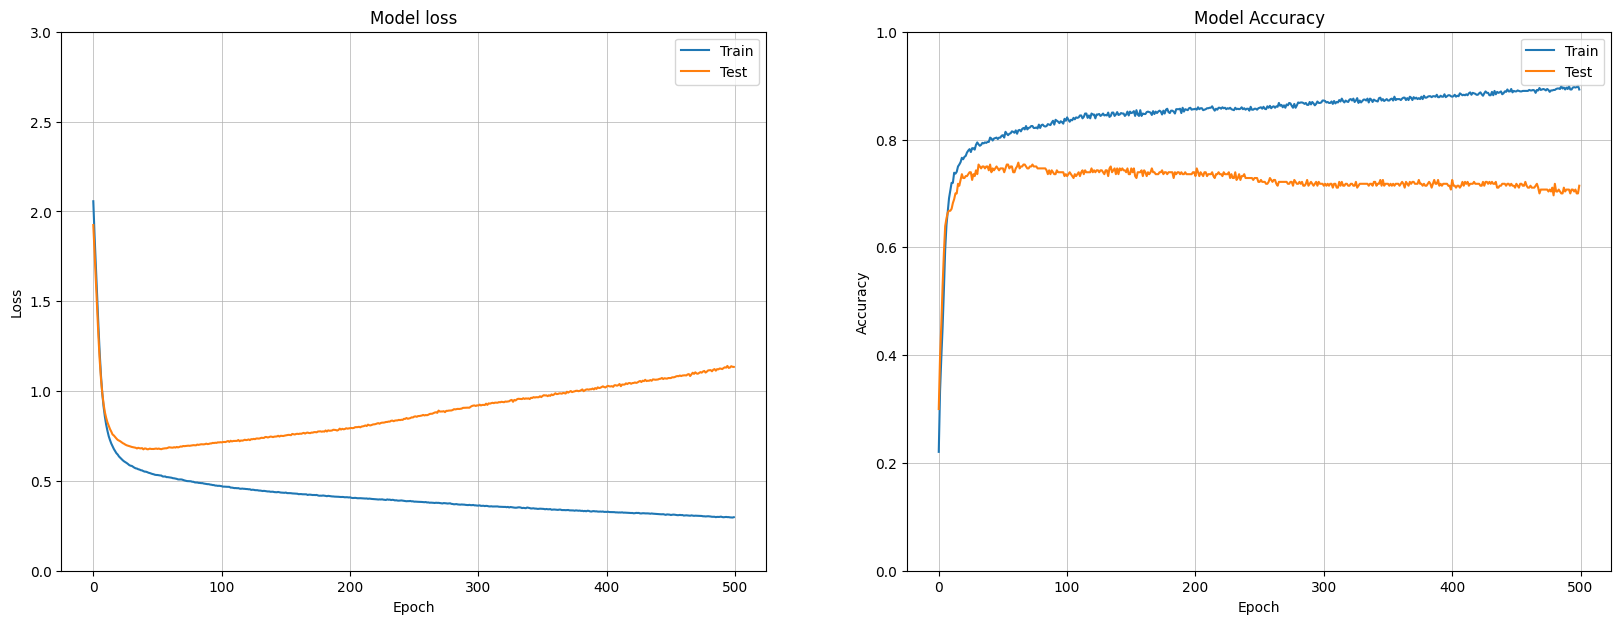

In [15]:
plot_loss_accuracy(history)

👩🏻‍🏫 We clearly see that **the number of epochs we choose has a strong influence on the final results**: 

**INSUFFICIENT NUMBER OF EPOCHS $\implies$ UNDERFITTING**:
- The algorithm is not optimal as its Loss Function has **not converged yet**
- It hasn't learned enough from the training data

**TOO MANY EPOCHS** $\implies$ **OVERFITTING**: 
- Our Neural Network has **learned too much** from the training data, including its noisy information
- the algorithm **does not generalize well** on test data

🚦 Basically, what we want to do is stop the algorithm **when the test loss is minimal** (or when the testing metrics are maximal)

#### Early Stopping

🧑🏻‍🏫 Let's introduce the **Early Stopping** criterion.

The Early Stopping criterion is a way to **automatically stop the training of the algorithm** before reaching the number of epochs that was originally set.

🕵🏻‍♂️ **How does it work?**

The model will pay attention to the **<font color=green>loss of the validation set</font>**. If <font color=green>it</font> starts increasing again 📈 while the <font color=blue>loss of the training set</font> keeps decreasing 📉, it is a good sign that the model is overfitting and the training should be stopped!


<img src="validation_set.png" alt="Validation set" width=450/>

##### Observing the Early Stopping Criterion

Run the following code and plot the history.

In [24]:
%%time

es = EarlyStopping()

model = initialize_model(10, 8)

# Fit the model on the train data
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 500,
    batch_size = 16, 
    verbose = 1, 
    callbacks = [es] # This will call the Early Stopping Criterion for each epoch
)

Epoch 1/500
62/62 [==============================] - 1s 4ms/step - loss: 2.0701 - accuracy: 0.1553 - val_loss: 2.0028 - val_accuracy: 0.1876
Epoch 2/500
62/62 [==============================] - 0s 2ms/step - loss: 1.9137 - accuracy: 0.2707 - val_loss: 1.8511 - val_accuracy: 0.3135
CPU times: user 860 ms, sys: 101 ms, total: 960 ms
Wall time: 840 ms


##### Evaluate the ES Model

_(also look at the historical losses)_

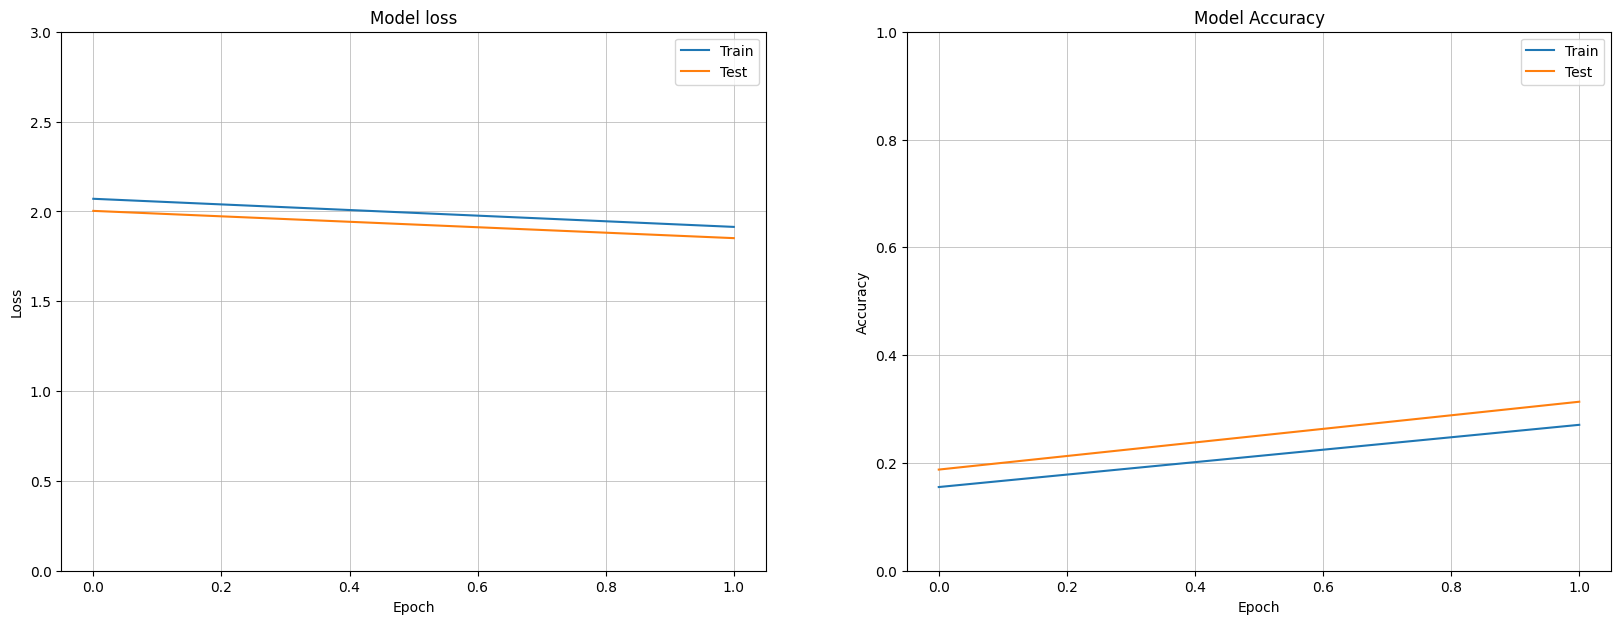

In [25]:
plot_loss_accuracy(history)

❗ **The problem with strict Early Stopping** ❗ 

The problem with this type of approach is that as soon as the loss of the validation set increases, the model stops. However, as a Neural Network's convergence is stochastic, the loss may slightly increase before decreasing again.

✅ The `EarlyStopping` criterion has a `patience` keyword that defines how many **consecutive epochs without any loss decrease** are allowed in the validation set before we stop the training procedure.

Use the `EarlyStopping` criterion with a patience term of 30 epochs, plot the results, and print the accuracy on the testing set

Epoch 1/100
44/44 [==============================] - 0s 3ms/step - loss: 1.7616 - accuracy: 0.3900 - val_loss: 1.8086 - val_accuracy: 0.4736
Epoch 2/100
44/44 [==============================] - 0s 2ms/step - loss: 1.2791 - accuracy: 0.5529 - val_loss: 1.7696 - val_accuracy: 0.5750
Epoch 3/100
44/44 [==============================] - 0s 2ms/step - loss: 1.0589 - accuracy: 0.6293 - val_loss: 1.7144 - val_accuracy: 0.6307
Epoch 4/100
44/44 [==============================] - 0s 2ms/step - loss: 0.9300 - accuracy: 0.6736 - val_loss: 1.6722 - val_accuracy: 0.6514
Epoch 5/100
44/44 [==============================] - 0s 2ms/step - loss: 0.8429 - accuracy: 0.7043 - val_loss: 1.6340 - val_accuracy: 0.6793
Epoch 6/100
44/44 [==============================] - 0s 2ms/step - loss: 0.7879 - accuracy: 0.7314 - val_loss: 1.6104 - val_accuracy: 0.6857
Epoch 7/100
44/44 [==============================] - 0s 2ms/step - loss: 0.7449 - accuracy: 0.7393 - val_loss: 1.5923 - val_accuracy: 0.6950
Epoch 8/100
4

Epoch 59/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4764 - accuracy: 0.8107 - val_loss: 1.4479 - val_accuracy: 0.6007
Epoch 60/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4714 - accuracy: 0.8279 - val_loss: 1.4494 - val_accuracy: 0.5964
Epoch 61/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4730 - accuracy: 0.8207 - val_loss: 1.4405 - val_accuracy: 0.6114
Epoch 62/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4735 - accuracy: 0.8221 - val_loss: 1.4485 - val_accuracy: 0.5843
Epoch 63/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.8243 - val_loss: 1.4436 - val_accuracy: 0.5936
Epoch 64/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4654 - accuracy: 0.8229 - val_loss: 1.4443 - val_accuracy: 0.5971
Epoch 65/100
44/44 [==============================] - 0s 2ms/step - loss: 0.4656 - accuracy: 0.8229 - val_loss: 1.4453 - val_accuracy: 0.5907
Epoch 

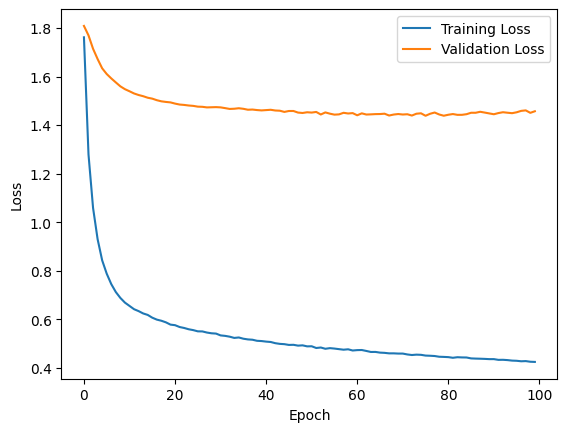

19/19 [==============================] - 0s 808us/step - loss: 0.9078 - accuracy: 0.7017
Testing accuracy: 70.17%


In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(x_train, y_train, epochs=100, validation_data=(X_train_scaled, y_train), callbacks=[callback])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = model.evaluate(x_test, y_test)[1]
print(f"Testing accuracy: {accuracy*100:.2f}%")


🧑🏻‍🏫 **Remarks**


- 📉 The model continues to converge even though its Loss Function had some consecutive loss increases/decreases w.r.t. to the number of epochs
- 🤷🏻‍♂️ The `patience` number to select is highly related to the task at hand, and there is no general rule of thumb
- 🧑🏻‍🏫 If you selected a high patience value for your Early Stopping:
    - 🤞 your Neural Network should theoretically still stop training before the end (not always the case if your number of epochs is too low)
    - ❗️ your validation loss will increase again after reaching a minimum value, but ideally, you want it to be as low as possible; the validation loss potentially reaches a minimum for certain weights at a certain epoch
        - 🤔 How to find these weights?

📚 The `EarlyStopping` criterion enables you to:
- stop the convergence
- restore the best weights of the NN when it had the lowest error level (or the best score) on the validation set, thanks to `restore_best_weights = True` (set to `False` by default)

##### Restoring the Best Weights of a Model

- Run the model with an Early Stopping criterion that will restore the best weights of the Neural Net
- Plot the loss and accuracy 
- Print the accuracy on the testing set

In [ ]:
# YOUR CODE HERE

🥡 **Takeaways from the Early Stopping criterion:**

- You can look at the 📚 [**Early Stopping documentation**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to play with other parameters
- You no longer need to have a look at the number of epochs as long as the model hits the stopping criterion. So, in the future, you should set a large number of epochs and the Early Stopping criterion will take care of stopping the training procedure before the model overfits! 

### (2.2) Batch Size & Epochs

🕵️‍♀️ Let's investigate the impact of the batch size on training a Neural Network and how we can use it to control how fast the parameters are updated.

#### Playing with the Batch Size

Let's run the previous model with **different batch sizes** (with the Early Stopping criterion included) and plot the results.

👉 Run the following cell

In [ ]:
%%time
# RUN THIS CELL
es = EarlyStopping(patience=20, restore_best_weights=True)

for batch_size in [1, 4, 32]:
    
    model = initialize_model()

    history = model.fit(
        X_train_scaled,
        y_train,
        validation_split = 0.3,
        epochs = 500,
        batch_size = batch_size, 
        verbose = 0, 
        callbacks = [es]
    )

    results = model.evaluate(X_test_scaled, y_test, verbose=0)
    plot_loss_accuracy(history, title=f'------ BATCH SIZE {batch_size} ------\n The accuracy on the test set is of {results[1]:.2f}')

#### ❓Question: Impact of the Batch Size on the Convergence of a Neural Network

Look at the oscillations of the accuracy and the loss according to the batch size number. 

Is this coherent with what we saw when playing with the TensorFlow Playground? 

> Your answer here

#### ❓Question: Number of Parameter Updates

How many weight optimizations are done within one epoch (considering the number of observations and the batch size)? Does one epoch have more weight updates with a large or with a small batch size?

> Your answer here

#### Explanations

Copy and paste this code into a new cell, run it, and observe.
        
```python
print(f"There are {X_train.shape[0]} rows in the training set")

batch_size = 16
epochs = 2

model = initialize_model()

history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1
)
```        


<u><b>Number of parameter updates:</b></u>

- There are 1400 rows in the training set:
    - $ 70 \% \times 1400 = 980 $ rows are used as the training set within the training set
    - $ 30 \% \times 1400 = 420 $ rows are used as the validation set  
- For each epoch, we run a forward/backward propagation $ \large \lceil \frac{980}{batch size} \rceil = \lceil \frac{980}{16}\rceil = 62$ times
- Without the Early Stopping Criterion, we will have _number of_ $ epochs \times 62 = 2 \times 62 = 124 $ iterations overall
        
<u><b>Impact of the batch size:</b></u>

The smaller the batch size 

$ \implies $ The more sub-iterations will be done  
$ \implies $ Parameters will be updated more frequently  
$ \implies $ We may need fewer epochs  

_(but we also don't care too much about the number of epochs if we use an Early Stopping Criterion with a patience term anyway)_    

In [ ]:
batch_size = 16
epochs = 2

model = initialize_model()

history = model.fit(
    X_train_scaled, 
    y_train,
    validation_split = 0.3,
    epochs = epochs,
    batch_size = batch_size, 
    verbose = 1
)

### (2.3) Regularization

❗️**Neural Networks with complex architectures can quickly lead to overfitting** (_too many layers and/or neurons_)❗️

🔥 But since Dense Neural Networks are just activated linear regressions, the weights can be constrained using L1, L2, or L1-L2 penalties!

🚓 So, let's apply some L2 or L1 penalties to these neurons; as in Machine Learning, these penalties are called **`Regularizers`**.

📚 <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers">See `tf.keras.regularizers`</a>

#### Observing Overfitting Before Regularizing

First, let's initialize a model that has too many parameters for the task such that it overfits the training data quickly. To that purpose, let's not use any Early Stopping criterion.

🎁 Let's not waste time re-coding something that you are now used to, just run the following cell and observe what is happening 👇

In [ ]:
# RUN THIS CELL

# 1. Model Architecture
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_dim=10))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

# 2. Model Compilation
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 3. Training 
history = model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 300,           # Notice that we are not using any Early Stopping Criterion
    batch_size = 16, 
    verbose=0
)

# 4. Evaluation
results_train = model.evaluate(X_train_scaled, y_train, verbose = 0)
results_test = model.evaluate(X_test_scaled, y_test, verbose = 0)


# 5. Looking back at what happened during the training phase
print(f'The accuracy on the testing set is {results_test[1]:.2f}...')
print(f'...whereas the accuracy on the training set is {results_train[1]:.2f}!')
plot_loss_accuracy(history)

☝️ In our "over-parameterized network", some neurons became **too specific for the given training data**, preventing the network from generalizing to new data.

😕 This led to some overfitting! 

#### Studying the Impact of Regularization on the Neural Network

Change the previous code to integrate an L2 or L1 regularizer into your Dense Layers.

In [ ]:
# YOUR CODE HERE

### (2.4) Dropout Layers

#### Introduction to Dropout Layers

The role of a Dropout Layer is to randomly cancel the output of some neurons during the training phase, it prevents the network from getting too specific for the input data.

Dropout Layers
- ensure that no neuron can overspecialize in learning a pattern of the dataset because its output is sometimes canceled
- force the information of an input to be spread across multiple neurons instead of only one specific neuron
- are super straightforward to code 👌
  - but what is going on _under the hood_? 👩🏻‍🏫

#### Optional Reading

<details>
    <summary>Click here for further explanations about Dropout Layers</summary>

🤔 Remember what we said about neurons becoming **too specific**? 

**`BEGIN_EXPLANATIONS_ABOUT_DROPOUT_LAYERS`**

---

⚽️  **A Football Analogy:**

Think about a football team. There are 11 players on the pitch, but there are also players on the bench. Why? 
- The coach may want to substitute injured or tired players during the game
- The team may be
    - losing the game and willing to substitute a midfielder with a more **versatile player** who can be more offensive (= **mix of** midfielder/attacker roles) 
    - winning the game and would like to secure the result by replacing a midfielder with a more **versatile player** who can be more defensive (= **mix of** midfielder/defense roles)

💡 Well, in a Neural Net, there is also a risk that a neuron over-specializes in detecting one pattern, where it would be advisable to keep it more versatile.

---

📚 **The goal of [Dropout Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) is to prevent neurons from over-specializing.**

🧑🏻‍🏫 How do Dropout Layers work?

👉 When we apply a **Dropout rate** of 20% to a layer $k$, 20% of the **selected neurons** will have their weights **temporarily set to 0** , which has the following consequences:
1. A neuron computed at layer $k + 1$ considers all the weights as usual, but since some of them were temporarily set to 0, they were “ignored” while creating the neurons of this layer $k + 1$
2. Once a batch of data points has been seen by the Neural Network (**forward propagation**) and 80% of the weights in a layer have been optimized/updated (**backward propagation** with the **Adam** optimizer), the Neural Network moves on to the forward propagation of the next batch, where it will use:
   - 80% of the weights; the ones that were updated
   - 20% of the weights; the ones that were previously ignored and had their values **temporarily** set to 0

Based on these weights, we will go through this Dropout Layer again, which is going to temporarily ignore another 20% of the weights of a given layer. Be careful, the selection of this 20% is random, so the weights that will be ignored this time won't necessarily be the same as before!

👉 Think about the **Dropout rate** as a **sampling with replacement**

👉 By **randomly shutting down** different neurons at different epochs, we force the data points to be **analyzed by different neurons**. At the end of the day, these neurons will become **more versatile** instead of over-specializing!
   
---

**`END_EXPLANATIONS_ABOUT_DROPOUT_LAYERS`**
</details>

#### Studying the Impact of Dropout Layers on the Neural Network

Include some Dropout layers in the architecture of your original model _(don't add regularizers here)_.

What can you observe regarding the convergence of your model? What about its ability to generalize?

In [ ]:
# YOUR CODE HERE

## (3) Conclusions

- ❗️ If you train a Neural Network too much (too many layers, too many neurons, and/or too many epochs), it will overfit very quickly
- 🥊 To prevent overfitting in Deep Learning, you can use Early Stopping, Regularization, and Dropout Layers
- ❗️ Be careful, if you use these techniques, you might end up on the other spectrum of the performance where your model would underfit the dataset!
- 🆗 You could potentially look at the batch size but we usually use 16 or 32; and as the French Computer Scientist [**Yann Lecun**](https://en.wikipedia.org/wiki/Yann_LeCun) said (Facebook x NYU):

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/DL/deep_learning_yann_lecun_batch_size.png" alt="batch_size_yann_lecun" width="500">

## 🏁 Congratulations!

💾 Do not forget to `git add/commit/push` your notebook...

🚀 ... and move to the next challenge!